<a href="https://colab.research.google.com/github/tensorvijay/Mtechcen/blob/master/SETI_Signal_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import time
import itertools

from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras import callbacks
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.regularizers import l1
from keras.applications import ResNet50
from keras.layers import Dense, LeakyReLU, Flatten, Dropout, GlobalAveragePooling2D, Conv2D, AveragePooling2D
from keras.utils.np_utils import to_categorical

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

We will start by defining some global constants which includes hyper-parameters as well. I will be adding more comments/explanation about the model and classification as I get some time.

In [ ]:
# some global constants
sclasses = ["brightpixel",
            "narrowband",
            "narrowbanddrd",
            "noise",
            "squarepulsednarrowband",
            "squiggle",
            "squigglesquarepulsednarrowband"]

model_name = "seti_model"
epochs = 10
learning_rate = 0.00146
batch_size = 50
steps_per_epoch = 150
output_classes = len(sclasses)
loss = "categorical_crossentropy"
parameter_scaling = 36
regularizer = 0.0 #1.0e-7
model_location = "./model"
tensorboard = "./tensorboard"
channels = 1
preprocess = True
clip_outliers = True
preprocess = True
gaussian_blurr = False
augument = True
augument_size = 200
image_width = 224
image_hieght = 224
input_shape = (image_width, image_hieght, channels)

In [ ]:
# pre process and image passed
def preprocess_image(image, resize=True, grayscale=False):
    # if grayscale
    if grayscale:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if clip_outliers:
        mean = np.mean(image)
        std = np.std(image)
        # clip all the values which are 3.5 standard deviations away from mean
        image = np.clip(image, mean-3.5*std, mean+3.5*std)
    if gaussian_blurr:
        image = cv2.GaussianBlur(image, (3, 3), 1)
    # morph close
    morphed = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel=np.ones((3, 3), dtype=np.float32))
    # gradient in both directions
    sobelx = cv2.Sobel(morphed, cv2.CV_64F, 1, 0, 2)
    sobely = cv2.Sobel(morphed, cv2.CV_64F, 0, 1, 2)
    # final weight with a concentration in horizontal gradient
    blended = cv2.addWeighted(src1=sobelx, alpha=0.7, src2=sobely, beta=0.3, gamma=0)
    if resize:
        resized = cv2.resize(blended, (image_width, image_hieght))
    reshaped = resized.reshape(image_width, image_hieght, channels)
    _image = reshaped/255.0
    # start by resizing the image

    return _image

In [ ]:
def augument_images(images=None):
    datagen = ImageDataGenerator(width_shift_range=0.01,
                                 height_shift_range=0.01,
                                 zoom_range=0.01,
                                 shear_range=0.01,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 preprocessing_function=preprocess_image,
                                 rotation_range=3.0)
    #datagen.fit(images)
    #images_batch = next(datagen.flow(x=images, y=None, batch_size=augument_size))
    return datagen

In [ ]:
print('helloworld')

helloworld


In [ ]:
# gets the data from a directory, applies preprocessing to each image and stores in a numpy array
def get_data(primary_dir, augument=False):
    X = np.empty(shape=(0, image_width, image_hieght, channels))
    Y = np.empty(shape=(0, ))
    _global_index = -1
    for sclass in sclasses:
        # loop through directories
        sclass_dir = os.path.join(primary_dir, sclass)
        print("Sclass: {}".format(sclass))
        _x = []
        _y = []
        for index, filename in enumerate(os.listdir(sclass_dir)):
            if index % 200 == 0:
                print("Pre-processing {}st image in {} class".format(index+1, sclass))
            _global_index += 1
            _image = cv2.imread(os.path.join(sclass_dir, filename))
            _image = preprocess_image(_image, resize=True, grayscale=True)
            # into local list
            _x.insert(index, _image)
            _y.insert(index, sclass)
        # augument to generate more training data
        if augument:
            x_aug = augument_images(np.array(_x))
            y_aug = [sclass]*len(x_aug)
            _x.extend(x_aug.tolist())
            _y.extend(y_aug)
            _global_index += augument_size
            print("Augumented {} images for the class: \"{}\"".format(augument_size, sclass))
        _x = np.array(_x)
        _y = np.array(_y)
        # print("yshape: {}".format(_y.shape))
        # into global list
        X = np.append(X, _x, axis=0)
        Y = np.append(Y, _y, axis=0)
        print("Data Extraction complete for class: \"{}\"".format(sclass))
        encoder = LabelEncoder()
        Y = encoder.fit_transform(Y)
        print("Encoded target labels...")
        # print("Global Index: {}".format(_global_index))
    return X, Y

In [ ]:
"""
def model():
    scale = parameter_scaling
    # model architecture
    _model = Sequential()

    # convolution 1
    _model.add(Conv2D(scale, (3, 3), input_shape=input_shape))
    _model.add(LeakyReLU(alpha=0.1))
    _model.add(MaxPooling2D(pool_size=(2, 2)))
    _model.add(Dropout(0.2))

    # convolution 2
    _model.add(Conv2D(2*scale, (3, 3)))
    _model.add(LeakyReLU(alpha=0.1))
    _model.add(MaxPooling2D(pool_size=(2, 2)))
    _model.add(Dropout(0.1))

    # convolution 3
    _model.add(Conv2D(3*scale, (3, 3)))
    _model.add(LeakyReLU(alpha=0.1))
    _model.add(MaxPooling2D(pool_size=(2, 2)))
    _model.add(Dropout(0.1))

    # convolution 4
    _model.add(Conv2D(4*scale, (3, 3)))
    _model.add(LeakyReLU(alpha=0.1))
    _model.add(MaxPooling2D(pool_size=(2, 2)))
    _model.add(Dropout(0.1))

    # convolution 5
    _model.add(Conv2D(5*scale, (3, 3)))
    _model.add(LeakyReLU(alpha=0.1))
    _model.add(MaxPooling2D(pool_size=(2, 2)))
    _model.add(Dropout(0.1))

    # convolution 6
    _model.add(Conv2D(6*scale, (3, 3)))
    _model.add(LeakyReLU(alpha=0.1))
    _model.add(MaxPooling2D(pool_size=(2, 2)))
    _model.add(Dropout(0.1))

    # convolution 7
    _model.add(Conv2D(7*scale, (3, 3)))
    _model.add(LeakyReLU(alpha=0.1))
    _model.add(MaxPooling2D(pool_size=(2, 2)))
    _model.add(Dropout(0.1))

    # flattening layer
    _model.add(Flatten())

    # first dense layer
    _model.add(Dense(units=7*scale))
    _model.add(LeakyReLU(alpha=0.1))
    _model.add(Dropout(0.5))

    # second dense layer
    _model.add(Dense(units=7*scale))
    _model.add(LeakyReLU(alpha=0.1))
    _model.add(Dropout(0.5))

    # third dense layer
    _model.add(Dense(units=7*scale))
    _model.add(LeakyReLU(alpha=0.1))
    _model.add(Dropout(0.5))

    # output layer
    _model.add(Dense(output_classes, activation="softmax"))

    # optimizer
    _model.compile(Adam(lr=learning_rate), loss=loss, metrics=["accuracy"])
    print(_model.summary())
    return _model
"""






'\ndef model():\n    scale = parameter_scaling\n    # model architecture\n    _model = Sequential()\n\n    # convolution 1\n    _model.add(Conv2D(scale, (3, 3), input_shape=input_shape))\n    _model.add(LeakyReLU(alpha=0.1))\n    _model.add(MaxPooling2D(pool_size=(2, 2)))\n    _model.add(Dropout(0.2))\n\n    # convolution 2\n    _model.add(Conv2D(2*scale, (3, 3)))\n    _model.add(LeakyReLU(alpha=0.1))\n    _model.add(MaxPooling2D(pool_size=(2, 2)))\n    _model.add(Dropout(0.1))\n\n    # convolution 3\n    _model.add(Conv2D(3*scale, (3, 3)))\n    _model.add(LeakyReLU(alpha=0.1))\n    _model.add(MaxPooling2D(pool_size=(2, 2)))\n    _model.add(Dropout(0.1))\n\n    # convolution 4\n    _model.add(Conv2D(4*scale, (3, 3)))\n    _model.add(LeakyReLU(alpha=0.1))\n    _model.add(MaxPooling2D(pool_size=(2, 2)))\n    _model.add(Dropout(0.1))\n\n    # convolution 5\n    _model.add(Conv2D(5*scale, (3, 3)))\n    _model.add(LeakyReLU(alpha=0.1))\n    _model.add(MaxPooling2D(pool_size=(2, 2)))\n    _m

In [ ]:
def model():
    _model = ResNet50(
        weights= None,
        include_top=False,
        input_shape= (image_width, image_hieght, 1)
    )
    x = _model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.7)(x)
    predictions = Dense(output_classes, activation= "softmax")(x)
    model = Model(inputs = _model.input, outputs = predictions)
    return model

In [ ]:
def fit(model, train, X_val, y_val, save_model=False):
        # callbacks
        h_callbacks = [
            callbacks.TensorBoard(
                log_dir=tensorboard,
                write_graph=True,
                write_images=False
            )
        ]
        # train on default gpu
        with tf.device('/gpu:0'):
            config = tf.ConfigProto()
            config.gpu_options.allow_growth = True
            sess = tf.Session(config=config)
            # fit the data
            history = model.fit_generator(train,
                                          epochs=epochs,
                                          steps_per_epoch=steps_per_epoch,
                                          validation_data=(X_val, y_val),
                                          shuffle=True,
                                          verbose=1,
                                          callbacks=None)
        if save_model:
            # write model configs back
            with open(os.path.join(model_location, "{}.json".format(model_name)), "w") as model_json:
                model_json.write(model.to_json())
                print("Saved Model json to disk")
            # save weights to h5
            model.save_weights(os.path.join(model_location, "{}.h5".format(model_name)))
            print("Saved Model weights to disk")
        return history

In [ ]:
# wrapper for the fit just in case if needed additional functionality
def train(train, X_val, y_val):
        _model = model()
        _model.compile(loss="categorical_crossentropy",
                       optimizer="adam",
                       metrics=["accuracy"])
        history = fit(_model, train, X_val, y_val, save_model=False)
        return _model, history

In [ ]:
# train generator because the training data is large and having it in memory is expensive
image_generator = augument_images()
train_image_generator = image_generator.flow_from_directory(os.path.join("../input/primary_small/train"),
                                                           batch_size=batch_size,
                                                           color_mode="grayscale",
                                                           target_size=(image_width, image_hieght))

Found 5600 images belonging to 7 classes.


In [ ]:
X_val, y_val = get_data(os.path.join("../input/primary_small/valid"))
X_test, y_test = get_data(os.path.join("../input/primary_small/test"))

Sclass: brightpixel
Pre-processing 1st image in brightpixel class
Data Extraction complete for class: "brightpixel"
Encoded target labels...
Sclass: narrowband
Pre-processing 1st image in narrowband class
Data Extraction complete for class: "narrowband"
Encoded target labels...
Sclass: narrowbanddrd
Pre-processing 1st image in narrowbanddrd class
Data Extraction complete for class: "narrowbanddrd"
Encoded target labels...
Sclass: noise
Pre-processing 1st image in noise class
Data Extraction complete for class: "noise"
Encoded target labels...
Sclass: squarepulsednarrowband
Pre-processing 1st image in squarepulsednarrowband class
Data Extraction complete for class: "squarepulsednarrowband"
Encoded target labels...
Sclass: squiggle
Pre-processing 1st image in squiggle class
Data Extraction complete for class: "squiggle"
Encoded target labels...
Sclass: squigglesquarepulsednarrowband
Pre-processing 1st image in squigglesquarepulsednarrowband class
Data Extraction complete for class: "squi

In [ ]:
# encode labels
#encoder = LabelEncoder()
#encoder.fit(y_val)
#encoded_ = encoder.transform(y_val)
y_val = to_categorical(y_val, output_classes)

In [ ]:
# train for the given configs
__model, history = train(train_image_generator, X_val, y_val)

Epoch 1/10
150/150 [==============================] - 131s 873ms/step - loss: 2.0046 - acc: 0.3635 - val_loss: 8.2765 - val_acc: 0.1814
Epoch 2/10
150/150 [==============================] - 113s 751ms/step - loss: 1.5915 - acc: 0.4531 - val_loss: 4.9328 - val_acc: 0.2386
Epoch 3/10
150/150 [==============================] - 114s 759ms/step - loss: 1.4433 - acc: 0.5063 - val_loss: 11.7934 - val_acc: 0.2043
Epoch 4/10
150/150 [==============================] - 114s 758ms/step - loss: 1.4392 - acc: 0.5111 - val_loss: 9.1042 - val_acc: 0.1614
Epoch 5/10
150/150 [==============================] - 114s 761ms/step - loss: 1.4320 - acc: 0.5161 - val_loss: 4.4243 - val_acc: 0.3357
Epoch 6/10
150/150 [==============================] - 114s 759ms/step - loss: 1.1994 - acc: 0.5813 - val_loss: 1.7818 - val_acc: 0.4171
Epoch 7/10
150/150 [==============================] - 113s 757ms/step - loss: 1.1687 - acc: 0.5849 - val_loss: 8.2944 - val_acc: 0.1614
Epoch 8/10
150/150 [===========================

In [ ]:
y_hat = __model.predict(X_test)


In [ ]:

y_hat = np.argmax(y_hat, axis=1)

In [ ]:
encoder_test = LabelEncoder()
encoder_test.fit(y_test)
encoded_test = encoder_test.transform(y_test)
y_test = to_categorical(encoded_test, output_classes)
y_test = np.argmax(y_test, axis=1)

In [ ]:
print(y_test.shape)

(700,)


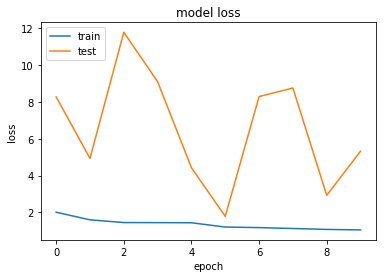

In [ ]:
# plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

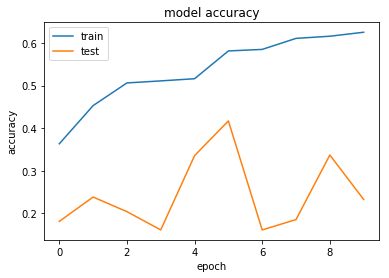

In [ ]:
# plotting accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print("Classification Report")
print(classification_report(y_test, y_hat, digits=5))

Classification Report
              precision    recall  f1-score   support

           0    0.95349   0.41000   0.57343       100
           1    0.18116   1.00000   0.30675       100
           2    0.00000   0.00000   0.00000       100
           3    0.00000   0.00000   0.00000       100
           4    0.18557   0.18000   0.18274       100
           5    1.00000   0.02000   0.03922       100
           6    1.00000   0.01000   0.01980       100

    accuracy                        0.23143       700
   macro avg    0.47432   0.23143   0.16028       700
weighted avg    0.47432   0.23143   0.16028       700



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
print("Accuracy: {}".format(accuracy_score(y_test, y_hat)))

Accuracy: 0.23142857142857143


In [ ]:
print(y_test)

[4 0 4 0 4 1 0 1 0 4 4 0 1 0 1 4 0 1 1 4 1 1 4 1 0 1 0 1 1 1 4 4 4 4 0 0 0
 0 0 0 1 1 0 0 4 0 1 1 4 1 0 0 1 4 1 0 0 4 1 1 0 1 0 0 1 0 1 0 4 1 0 0 0 0
 1 1 1 0 0 4 4 1 0 0 4 4 4 1 0 1 4 0 0 0 0 1 0 1 4 4 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 4
 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 4 1 1 4 1 1
 1 1 1 1 1 1 1 1 1 4 1 4 1 1 1 1 4 1 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 4
 4 4 1 4 1 1 4 1 1 1 1 1 